# Matrices creuses dans `scipy.sparse`
Nous introduisont ce module jusqu'à être capable de résoudre une équation aux dérivées partielles simple par une méthode de différences finies. Nous aurons besoin des modules suivant.

In [1]:
import numpy as np              # Grands tableaux de nombres
import scipy.sparse as sparse   # Algèbre linéaire creuse
import matplotlib.pyplot as plt # Pour les graphiques

Quelques exemples de matrices creuses: l'identité et une matrice creuse générée aléatoirement. On peut représenter graphiquement les coefficients non nuls de ces matrices pour avoir une idée de leur remplissage, qui s'appelle le *profil*.

In [2]:
Id_sp = sparse.eye(10)
print("Matrice Identité au format creux: \n{}".format(Id_sp))
print(type(Id_sp))

Matrice Identité au format creux: 
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
<class 'scipy.sparse.dia.dia_matrix'>


Voilà la visualisation des coefficients non nul, sur deux exemples.

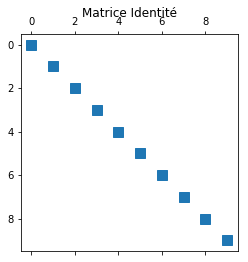

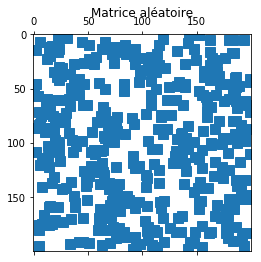

<class 'scipy.sparse.coo.coo_matrix'>


In [5]:
Id_sp = sparse.eye(10)
plt.spy(Id_sp)
plt.title("Matrice Identité")
plt.show()

A = sparse.rand(200,200, density=0.01)
plt.spy(A)
plt.title("Matrice aléatoire")
plt.show()
print(type(A))

In [6]:
print(type(A))

<class 'scipy.sparse.coo.coo_matrix'>


Supposons maintenant que l'on souhaite résoudre le problème $au-\Delta u = f$ dans le carré $\Omega = (0,1) \times (0,1)$, avec $\partial_n u = 0$ sur le bord de $\Omega$. On suppose que $a>0$, et $f$ est une fonction donnée.

On construit une fonction qui renvoie la matrice de la discrétisation par différences finies de $u \mapsto -\Delta u$ dans le carré $(x_\text{min},x_\text{max}) \times (y_\text{min},y_\text{max})$ avec les conditions $\partial_n u = 0$ au bord. Le carré $\Omega$ est découpé en $N_x$ par $N_y$ sous-intervalles, ce qui donne une matrice de taille $(N_x+1)(Ny+1) \times (N_x+1)(Ny+1)$.

In [8]:
def matrix_neumann2D(Omega,Nx,Ny):
    """Returns the matrix that discretizes the mapping u --> -Laplacian(u)
on the domain Omega = [xmin,xmax,ymin,ymax] split into Nx parts in x
and Ny parts in y. The final matrix is a scipy.sparse CSR matrix. It
is of size (Nx+1)*(Ny+1)."""
    
    hx = (Omega[1]-Omega[0])/Nx
    hy = (Omega[3]-Omega[2])/Ny
    hx2 = hx*hx
    hy2 = hy*hy

    # Les inconnues sont numérotés de 0 à Nx suivant x et 0 à Ny
    # suivant y. La taille du problème est donc (Nx+1)*(Ny+1).

    # Cela correspond à x_i = i*hx et y_j = j*hy, et la numérotation (i,j) --> k
    # := (Nx+1)*j + i pour i=0 à Nx et j = 0 à Ny.
 
    # Pour -Laplacien(u), la matrice est constituée de (Ny+1)x(Ny+1)
    # blocs de taille (Nx+1)x(Nx+1), de la forme
    #
    # A = [ A0 B              ]
    #     [ B  A1 B           ]
    #     [    B  A1 B        ]
    #     [       .  .  .     ]
    #     [           B A1 B  ]
    #     [             B  A0 ]
    #
    # Au final, on peut commencer à remplir avec des diagonales
    N = (1+Nx)*(1+Ny)
    diags = np.zeros((5,N))
    # La diagonale est constante
    diags[2,:] = 2./hx2+2./hy2
    # Diagonale -1
    diags[1,:] = -1./hx2                      # en général
    diags[1,np.arange(Nx,N,Nx+1)] = 0.        # bord gauche
    diags[1,np.arange(Nx-1,N,Nx+1)] = -2./hx2 # bord droit
    # Diagonale +1
    diags[3,:] = -1./hx2                   # en général
    diags[3,np.arange(0,N,Nx+1)] = 0.      # bord droit
    diags[3,np.arange(1,N,Nx+1)] = -2./hx2 # bord gauche
    # Diagonale -(Nx+1)
    diags[0,:] = -1./hy2                       # en général
    diags[0,(Nx+1)*(Ny-1):(Nx+1)*Ny] = -2./hy2 # bord bas
    # Diagonale +(Nx+1)
    diags[4,:] = -1./hy2             # en général
    diags[4,Nx+1:2*(Nx+1)] = -2./hy2 # bord haut

    # Construction de la matrice creuse de u --> -Laplacien(u)
    A = sparse.spdiags(diags,[-(Nx+1),-1,0,1,(Nx+1)], (Nx+1)*(Ny+1),
                       (Nx+1)*(Ny+1), format="csr")

    return A

Munis de cette fonction, nous pouvons simplement résoudre notre problème. Il nous suffit de connaître la numérotation des sommets (ie l'ordre des inconnues dans les vecteurs), qui est $k = i + j(Nx+1)$ pour $i=0\ldots N_x$ et $j = 0\ldots N_y$.

Définissons le domaine et sa discrétisation.

In [15]:
Omega = np.array([0.,1.,0.,1.])
Nx,Ny = 40,40

La fonction $f$ du second membre de l'équation, et le coefficient $a$.

In [16]:
def f(x,y):
    return 1.
a = 1.

Nous pouvons alors calculer le vecteur second membre du système linéaire, par exemple en faisant une boucle sur les points du maillage. Une méthode plus efficace consisterait à vectoriser cette fonction.

In [17]:
x = np.linspace(Omega[0],Omega[1],Nx+1)
y = np.linspace(Omega[2],Omega[3],Ny+1)
F = np.zeros((Nx+1)*(Ny+1)) # Allocation mémoire
for i in np.arange(Nx+1):
    for j in np.arange(Ny+1):
        k = i+j*(Nx+1)
        F[k] = f(x[i],y[j])

Nous allouons la mémoire pour la solution, calculons la matrice du système linéaire, la visualisons. La matrice a seulement 5 diagonales nous nulles.

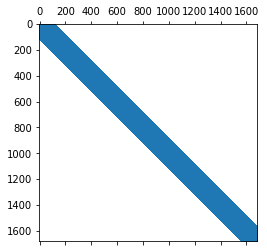

In [18]:
U = np.zeros((Nx+1)*(Ny+1))
A = matrix_neumann2D(Omega,Nx,Ny) + a*sparse.identity((Nx+1)*(Ny+1))
plt.spy(A)
plt.show()

Et nous pouvons résoudre le système linéaire.

In [22]:
from scipy.sparse.linalg import spsolve
U = spsolve(A,F)

Avec $f(x,y) = 1$, la solution du problème est $u(x,y) = 1$. Nous pouvons vérifier l'erreur commise par notre méthode, alors que celle-ci devrait être exacte dans ce cas. C'est à dire que l'on devrait trouver que `U==1`.

In [23]:
V = np.ones((Nx+1)*(Ny+1)) # Solution exacte
hx,hy = (Omega[1]-Omega[0])/Nx, (Omega[3]-Omega[2])/Ny
print("{:8s} {:12s} {:12s} {:12s}".format("Taille", "hx", "hy", "erreur L^2"))
print("{:8d} {:12.5e} {:12.5e} {:12.5e}".format((Nx+1)*(Ny+1), hx,hy, np.sqrt(hx*hy)*np.linalg.norm(V-U)))

Taille   hx           hy           erreur L^2  
    1681  2.50000e-02  2.50000e-02  9.00614e-14


Le tracé de la solution se fait avec un toolkit de `matplotlib`, qui est documenté sur internet.

In [26]:
print(U-1)

[8.81517082e-14 8.83737528e-14 8.85957974e-14 ... 7.97140132e-14
 7.97140132e-14 7.97140132e-14]


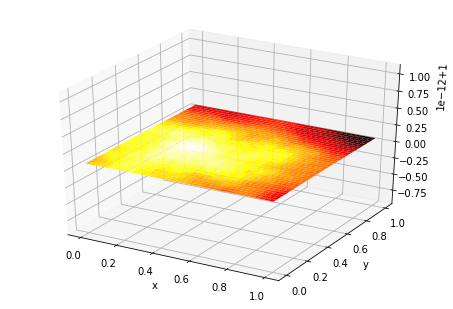

In [24]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((Nx+1,Ny+1)), cmap='hot')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Autre cas avec, plus intéressant, est obtenu avec $u = \cos(k\pi x)*\cos(k\pi y)$, qui vérifie bien $\partial_n u = 0$ sur le bord de $\Omega = (0,1)\times (0,1)$, et pour laquelle on a $-\Delta(u) = 2(k\pi)^2 u$, ce qui fait que l'on obtient $u$ comme solution si l'on prend $f = (a+2k^2\pi^2)\cos(k\pi x)*\cos(k\pi y)$.

Reprenons l'étude suivante dans ce cas...

Taille   hx           hy           erreur L^2  
 1002001  1.00000e-03  1.00000e-03  3.70643e-06


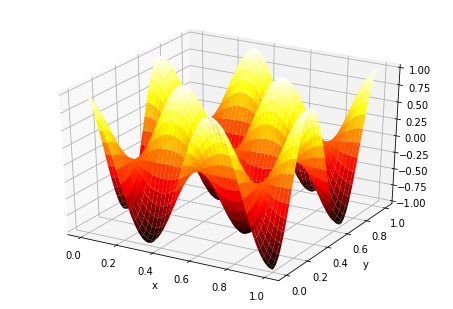

In [29]:
Omega = np.array([0.,1.,0.,1.])
Nx,Ny = 1000,1000 # 501*501 inconnues > 250 000 !

a = 0.1
q = 3.
def f(x,y):
    return (a + 2*(q*np.pi)**2) * np.cos(q*np.pi*x) * np.cos(q*np.pi*y)
def u(x,y):
    return np.cos(q*np.pi*x) * np.cos(q*np.pi*y)

x = np.linspace(Omega[0],Omega[1],Nx+1)
y = np.linspace(Omega[2],Omega[3],Ny+1)
F = np.zeros((Nx+1)*(Ny+1)) # second membre
V = np.zeros((Nx+1)*(Ny+1)) # solution exacte
for i in np.arange(Nx+1):
    for j in np.arange(Ny+1):
        k = i+j*(Nx+1)
        F[k] = f(x[i],y[j])
        V[k] = u(x[i],y[j])
        
U = np.zeros((Nx+1)*(Ny+1)) # solution approchée
A = matrix_neumann2D(Omega,Nx,Ny) + a*sparse.identity((Nx+1)*(Ny+1))

U = spsolve(A,F)

hx,hy = (Omega[1]-Omega[0])/Nx, (Omega[3]-Omega[2])/Ny
print("{:8s} {:12s} {:12s} {:12s}".
      format("Taille", "hx", "hy", "erreur L^2"))
print("{:8d} {:12.5e} {:12.5e} {:12.5e}".
      format((Nx+1)*(Ny+1), hx,hy, np.sqrt(hx*hy)*np.linalg.norm(V-U)))

fig = plt.figure()
ax = Axes3D(fig)

X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((Nx+1,Ny+1)), cmap='hot')
plt.xlabel("x")
plt.ylabel("y")

plt.show()